# Simple Siamese Network Implementation

Implementation is done to get understanding of how contrastive learn work, which will help to implement FYP project

### Dataset

Used AT&T Dataset

Can Be Found At : https://www.kaggle.com/datasets/kasikrit/att-database-of-faces

In [1]:
TRAINING_PATH = "att_data/training"

### Configure and Import Required Libraries

In [2]:
%matplotlib inline

In [3]:
import os
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from IPython.display import display
from PIL import Image

### Preparing Dataset

There are three persons in dataset. And each one containing 10 images. In order to train good neural network we need to precent class imbalance. Where we need to choose pair of images such that, 50% of images related to person and 50% images related to different person

Let's list all image paths and give tag

In [4]:
content_of_training_directory = os.listdir(TRAINING_PATH)
img_dict = []

for tag in content_of_training_directory:
    
    images_under_tag = os.listdir(TRAINING_PATH+"/"+tag)
    
    for image in images_under_tag:
        
        image_location = TRAINING_PATH+"/"+tag+"/"+image
        img = Image.open(image_location)
        
        img.convert("L")
        img.resize((100,100))
        
        transform = transforms.Compose([transforms.PILToTensor()])
        tensor = transform(img)
        img_dict.append((tensor, tag))

random.shuffle(img_dict)
img_dict[0]

(tensor([[[108, 112, 110,  ..., 119, 119, 122],
          [111, 110, 113,  ..., 121, 120, 120],
          [111, 111, 111,  ..., 119, 119, 120],
          ...,
          [ 23,  23,  20,  ...,  23,  35,  62],
          [ 27,  28,  23,  ...,  24,  20,  27],
          [ 25,  25,  19,  ...,  22,  30,  20]]], dtype=torch.uint8),
 's13')

Image Dict Contain Images And Tag as (PIL_IMAGE, TAG)

Now we need to make a batch with 50% similarity 

In [5]:
def load_a_batch(batchsize):
    
    # Content -> List Of (Image_1_Tensor, Image_2_Tensor, Is_Similar_Boolean)
    output_list = []
    
    # Select Similar Images
    for i in range(batchsize//2):
        img_1 = random.choice(img_dict)
        while True:
            img_2 = random.choice(img_dict)
            if img_1[1]==img_2[1]:
                output_list.append((img_1[0],img_2[0],True))
                break
    
    # Select Dissimilar Images
    for i in range(batchsize//2,batchsize):
        img_1 = random.choice(img_dict)
        while True:
            img_2 = random.choice(img_dict)
            if img_1[1]!=img_2[1]:
                output_list.append((img_1[0],img_2[0],False))
                break
    
    # Shuffle
    random.shuffle(output_list)
    
    # Return
    return output_list
                

We need a function to view a batch

In [6]:
def batch_image(batch):
    list_of_vertical_joined = []
    is_similar = []
    for i in range(len(batch)):
        res = torch.cat((torch.squeeze(batch[i][0]), torch.squeeze(batch[i][1])), 0)
        list_of_vertical_joined.append(res)
        is_similar.append(batch[i][2])
    res = list_of_vertical_joined[0]
    for i in range(1,len(list_of_vertical_joined)): 
        res = torch.cat((res, list_of_vertical_joined[i]), 1)
    return transforms.ToPILImage()(res),is_similar

[False, False, False, False, True, True, True, True, False, True]


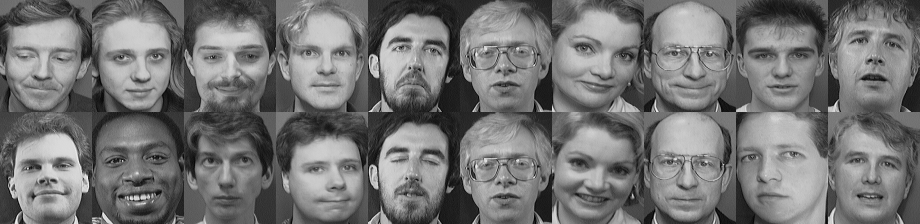

In [7]:
batch1 = load_a_batch(10)
img,is_similar = batch_image(batch1)
print(is_similar)
img

### Build Model

Here is how Siamese Network defined

![SiaMese Network Architecture](siamese.png)

In [8]:
class MySiameseNetwork(nn.Module):
    
    def __init__(self):
        super(MySiameseNetwork,self).__init__()
        
        self.cn_network = nn.Sequential(
            # Conv1
            nn.Conv2d(1,96,kernel_size =11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            
            # Conv2
            nn.Conv2d(96,256,kernel_size =5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            
            # Conv3
            nn.Conv2d(256,384,kernel_size =3, stride=1),
            nn.ReLU(),       
        )
        
        self.fc_network = nn.Sequential(            
            # FC 1 
            nn.Linear(768,1024),
            # FC 2
            nn.Linear(1024,256),
            # FC 2
            nn.Linear(256,2)                
        )
        
             
        
    def SendThroughNetwork(self,image):        
        out_cn = self.cn_network(image)
        shape = out_cn.shape
        flatten_out = out_cn.view(shape[0],-1)
        output = self.fc_network(flatten_out)
        return output
    
    def GetInputsAndLabels(self,batch):
        image_1_list=[]
        image_2_list=[]
        labels = []
        
        for img1,img2,label in batch:
            image_1_list.append(torch.unsqueeze(img1,0))
            image_2_list.append(torch.unsqueeze(img2,0))
            labels.append(torch.unsqueeze(torch.tensor(int(label)),0))
        
        return torch.cat(image_1_list,dim=0).float(),torch.cat(image_2_list,dim=0).float(),torch.cat(labels,dim=0).float()
    
    def forward(self,image_1,image_2):
        
        # Send Two Images Through Same Network
        output1 = self.SendThroughNetwork(image_1)
        output2 = self.SendThroughNetwork(image_2)
        
        return output1,output2
        

In [9]:
siamese_network = MySiameseNetwork()
image_1_batch,image_2_batch,labels_batch =siamese_network.GetInputsAndLabels(batch1)

In [10]:
image_2_batch.shape

torch.Size([10, 1, 112, 92])

In [13]:
x1,x2 = siamese_network(image_1_batch,image_2_batch)

### Define Loss

In [14]:
def ContastiveLoss(x1, x2, label, margin: float = 1.0):

    dist = torch.nn.functional.pairwise_distance(x1, x2)

    loss = (1 - label) * torch.pow(dist, 2) \
        + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
    loss = torch.mean(loss)

    return loss

In [15]:
ContastiveLoss(x1,x2,labels_batch)

tensor(0.4207, grad_fn=<MeanBackward0>)